In [ ]:
# 이미지 전처리 위해 train데이터로 채널별 평균, 표준편차 계산
# Compute per-channel mean and standard deviation from the training data for image preprocessing
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

calc_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_data = datasets.Food101(root="./data", split="train", transform=calc_transform, download=True)
train_loader = DataLoader(train_data, batch_size=64, shuffle=False)

mean = torch.zeros(3)
std = torch.zeros(3)
nb_samples = 0

for images, _ in train_loader:
  batch_samples = images.size(0)
  images = images.view(batch_samples, images.size(1), -1)
  mean += images.mean(2).sum(0)
  std += images.std(2).sum(0)
  nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples
print(mean)
print(std)

100%|██████████| 5.00G/5.00G [02:31<00:00, 33.0MB/s]


tensor([0.5450, 0.4435, 0.3436])
tensor([0.2302, 0.2409, 0.2387])


In [ ]:
# Train / Test Transform(전처리) 정의
# Define train and test transforms (preprocessing)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(96),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(96),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [ ]:
# Train, Test 데이터셋 불러오기
# Load Train, Test datasets
train_dataset = datasets.Food101(root="./data", split="train", transform=train_transform, download=True)
test_dataset = datasets.Food101(root="./data",split="test", transform=test_transform, download=True)

In [ ]:
# Dataloader 생성
# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
print(len(train_dataset))
print(len(test_dataset))
print(len(train_dataset.classes))
print(train_dataset.classes[:10])

75750
25250
101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


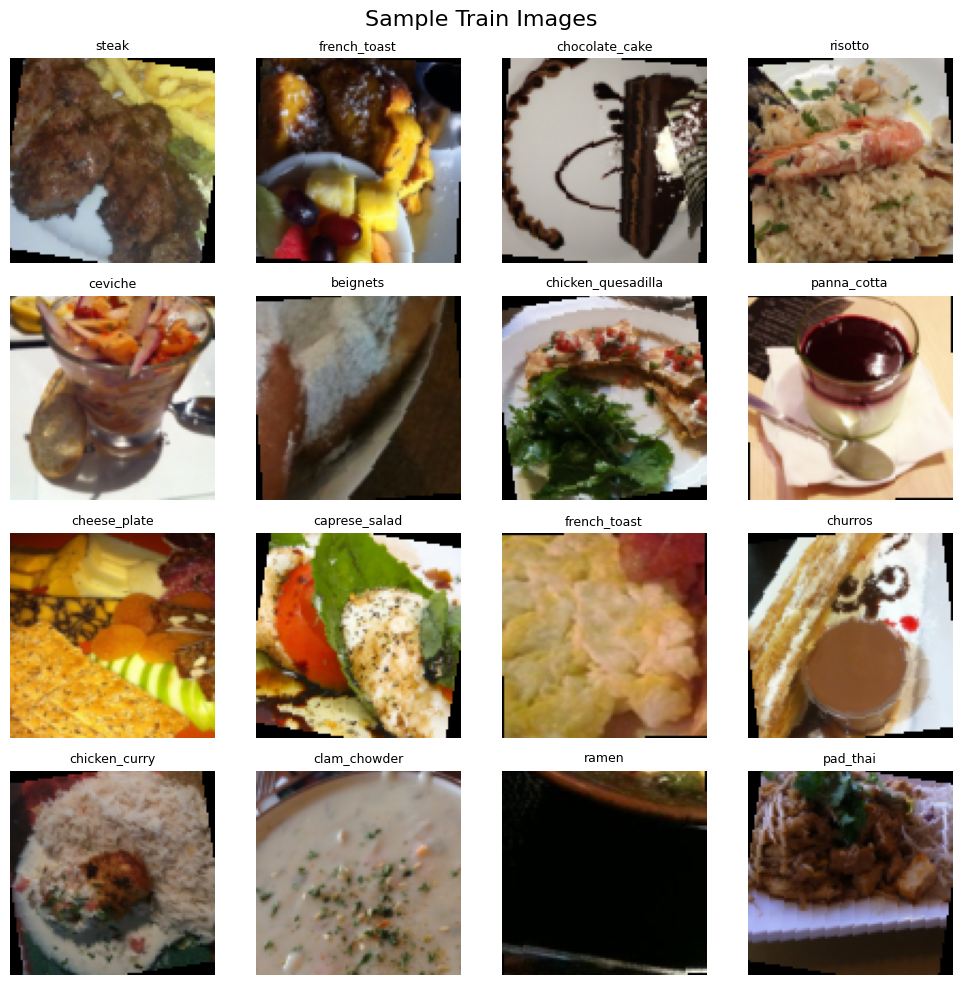

In [ ]:
# 이미지 시각화와 레이블 확인
# 시각화 위해 시각화용 데이터들 정규화 해제(원상태로 복원)
# Visualize images and verify labels
# Denormalize images to restore original pixel values for visualization

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
inv_normalize = transforms.Normalize(
    mean=[-m/s for m, s in zip(mean.tolist(), std.tolist())],
    std =[1/s for s in std.tolist()]
)

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("Sample Train Images", fontsize=16)

for i, ax in enumerate(axes.flat):
  img = inv_normalize(images[i]).permute(1, 2, 0).clamp(0, 1)
  label = train_dataset.classes[labels[i]]

  ax.imshow(img)
  ax.set_title(label, fontsize=9)
  ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cuda


In [ ]:
# 클래스로 CNN모델 생성
# Define a CNN model using a class

class Model(torch.nn.Module):
  def __init__(self, num_classes=101):
    super(Model, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(128, 128, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Conv2d(512, 512, kernel_size=3, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(512, 512, bias=False),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.mean(x, dim=(2, 3))
    x = self.classifier(x)
    return x

In [ ]:
# EarlyStopping, ModelCheckpoint 기능 클래스로 생성
# Define EarlyStopping and ModelCheckpoint callbacks as class

import numpy as np
import torch

class EarlyStopping:
  def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
    self.patience = patience
    self.verbose = verbose
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.inf
    self.delta = delta
    self.path = path

  def __call__(self, val_loss, model):
    score = -val_loss

    if self.best_score is None:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta:
      self.counter += 1
      if self.verbose:
        print(f"Earltstopping counter: {self.counter} out of {self.patience}")
      if self.counter >= self.patience:
        self.early_stop = True
    else:
      self.best_score = score
      self.save_checkpoint(val_loss, model)
      self.counter = 0

  def save_checkpoint(self, val_loss, model):
    if self.verbose:
      print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

In [ ]:
# 학습때 쓸 검증데이터 train데이터에서 분리
# Split validation data from the training set

from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Train, Validation DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# 훈련데이터로 모델학습
# Train the model using the training data

import torch
import torch.nn as nn
import torch.optim as optim

model = Model(num_classes=101).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

early_stopping = EarlyStopping(patience=5, verbose=True, path="best_model.pt")

num_epochs = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  train_loss = 0.0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    train_loss += loss.item() * images.size(0)

  model.eval()
  val_loss = 0.0
  with torch.no_grad():
    for images, labels in val_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      val_loss += loss.item() * images.size(0)

  train_loss /= len(train_loader.dataset)
  val_loss /= len(val_loader.dataset)
  print(f"Epoch [{epoch+1}/{num_epochs}]  Train Loss: {train_loss:.4f}  Val Loss: {val_loss:.4f}")
  train_losses.append(train_loss)
  val_losses.append(val_loss)

  early_stopping(val_loss, model)
  if early_stopping.early_stop:
    print("Early stopping triggered!")
    break


model.load_state_dict(torch.load('best_model.pt'))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/20]  Train Loss: 4.6085  Val Loss: 4.6137
Validation loss decreased (inf → 4.613717).  Saving model ...
Epoch [2/20]  Train Loss: 4.4394  Val Loss: 4.4977
Validation loss decreased (4.613717 → 4.497682).  Saving model ...
Epoch [3/20]  Train Loss: 4.3258  Val Loss: 4.3514
Validation loss decreased (4.497682 → 4.351410).  Saving model ...
Epoch [4/20]  Train Loss: 4.1734  Val Loss: 4.1338
Validation loss decreased (4.351410 → 4.133837).  Saving model ...
Epoch [5/20]  Train Loss: 4.0377  Val Loss: 4.0185
Validation loss decreased (4.133837 → 4.018469).  Saving model ...
Epoch [6/20]  Train Loss: 3.9300  Val Loss: 3.9779
Validation loss decreased (4.018469 → 3.977902).  Saving model ...
Epoch [7/20]  Train Loss: 3.8367  Val Loss: 3.8722
Validation loss decreased (3.977902 → 3.872236).  Saving model ...
Epoch [8/20]  Train Loss: 3.7406  Val Loss: 3.8703
Validation loss decreased (3.872236 → 3.870323).  Saving model ...
Epoch [9/20]  Train Loss: 3.6426  Val Loss: 3.7375
Validation

<All keys matched successfully>

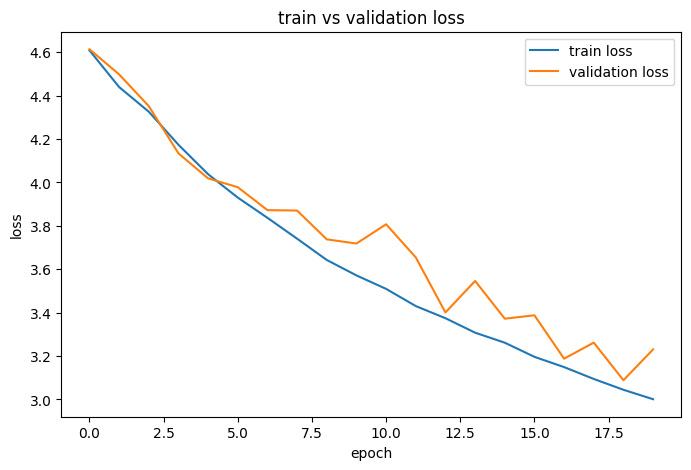

In [ ]:
# 학습때의 훈련,검증데이터 손실 시각화
# Visualize training and validation loss during training

import matplotlib.pyplot as plt

def plot_loss(train_losses, val_losses):
  plt.figure(figsize=(8,5))
  plt.plot(train_losses, label="train loss")
  plt.plot(val_losses, label="validation loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.title("train vs validation loss")
  plt.legend()
  plt.show()

plot_loss(train_losses, val_losses)

In [ ]:
# 테스트 데이터로 평가
# Evaluate on the test data

from sklearn.metrics import accuracy_score

def evaluate_model(model, test_loader, device):
  model.eval()
  all_preds = []
  all_labels = []
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      preds = torch.argmax(outputs, dim=1)
      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy())
  acc = accuracy_score(all_labels, all_preds)
  print(f"Test Accuracy: {acc:.4f}")
  return all_labels, all_preds

labels, preds = evaluate_model(model, test_loader, device)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.3402


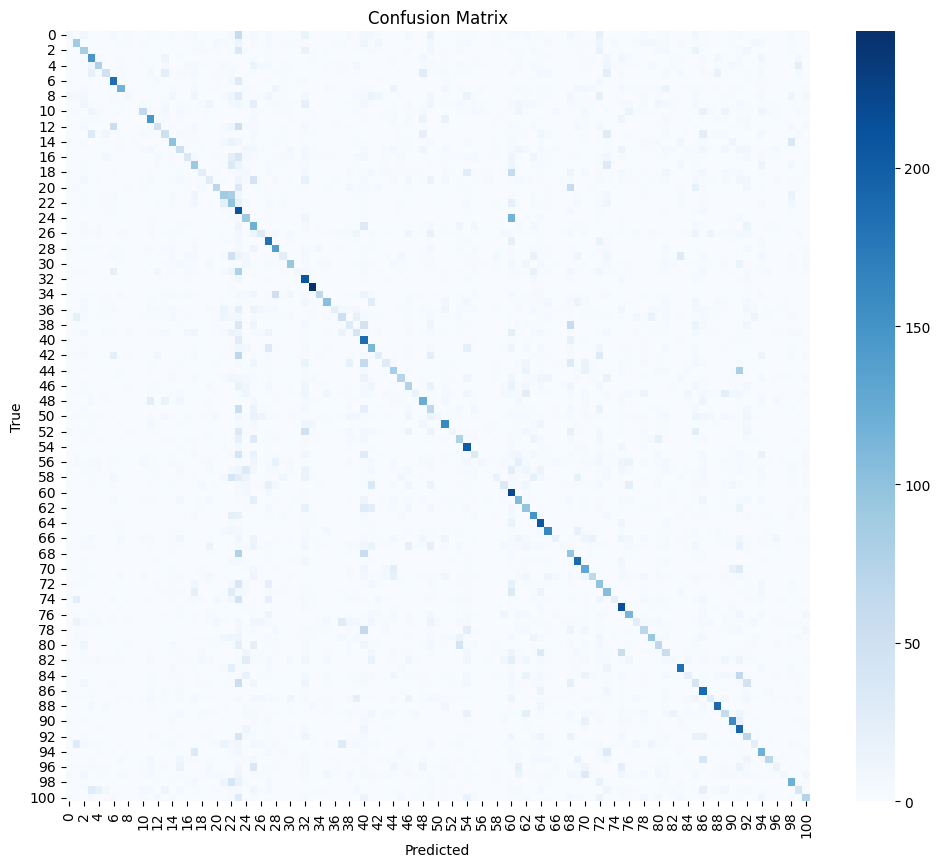

In [ ]:
# confusion_matrix로 테스트 결과 시각화
# Visualize test results using a confusion matrix

import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, class_names=None):
    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(12,10))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

train_dataset_full = datasets.Food101(root="./data", split="train", download=True)
plot_confusion_matrix(labels, preds, class_names=train_dataset_full.classes)

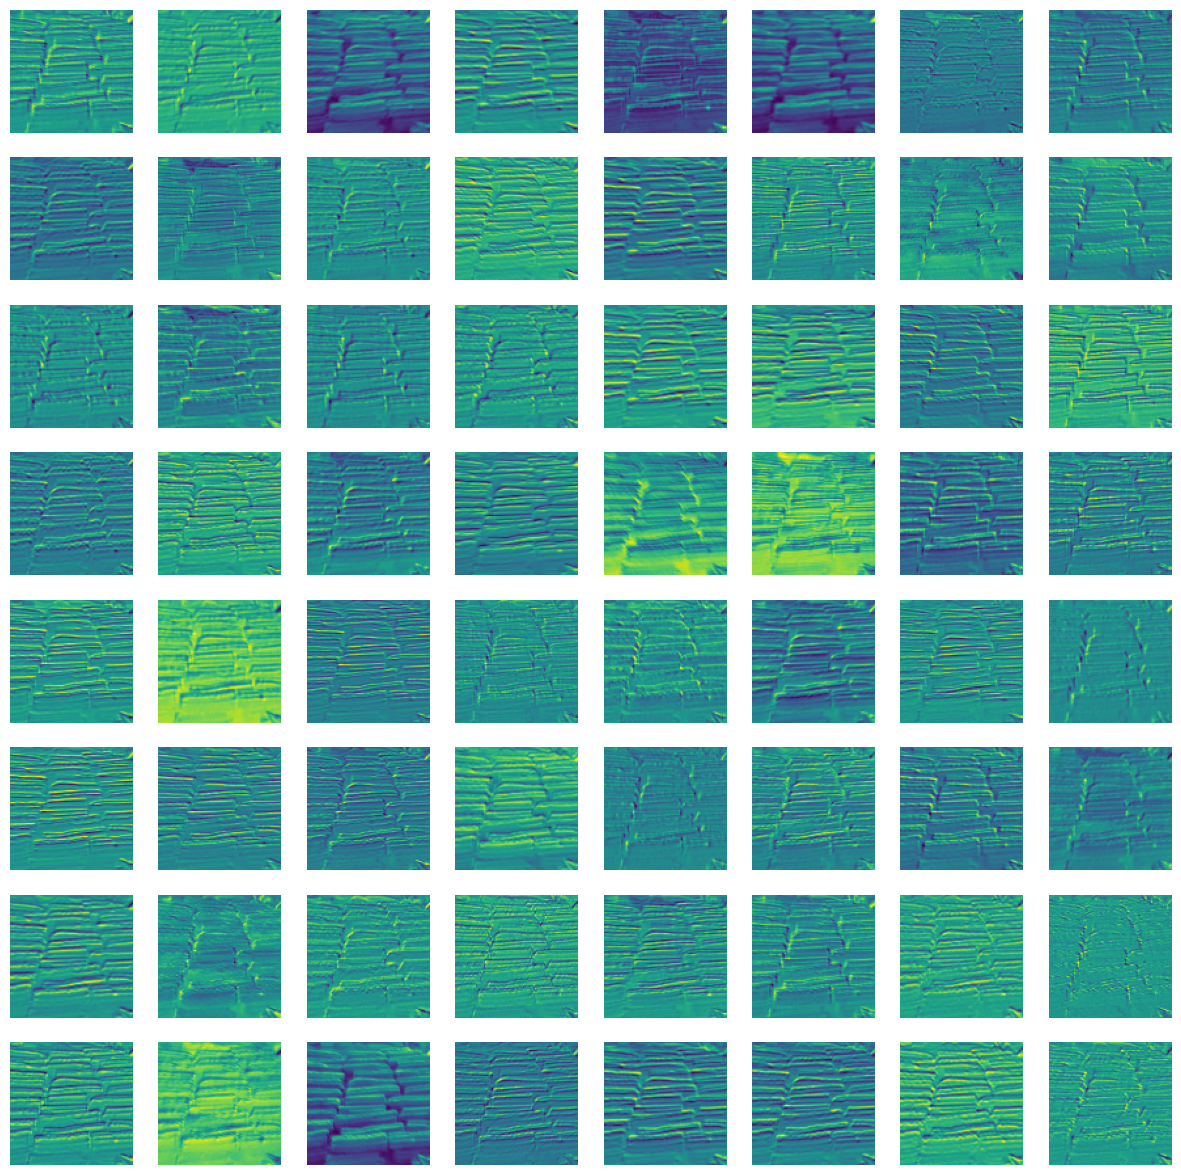

In [ ]:
# 데이터중 샘플이미지로 특성맵 시각화
# Visualize feature maps using sample images

def visualize_feature_maps(model, image, device, layer_idx=0):
    model.eval()
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        x = image
        for i, layer in enumerate(model.features):
            x = layer(x)
            if i == layer_idx:
                fmap = x.detach().cpu().squeeze(0)
                break
    # fmap 시각화
    # fmap visualization
    num_channels = fmap.shape[0]
    plt.figure(figsize=(15, 15))
    for i in range(min(num_channels, 64)):
        plt.subplot(8, 8, i+1)
        plt.imshow(fmap[i], cmap='viridis')
        plt.axis('off')
    plt.show()


sample_img, _ = next(iter(test_loader))
visualize_feature_maps(model, sample_img[0], device, layer_idx=0)